In [1]:
#импорт библиотек 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.dummy import DummyClassifier
import math
import time
import random
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import warnings


In [2]:
#считываем датасет из csv файла согласно варианту и выводим о нём соответствующую информацию
df = pd.read_csv('Housing_nan.csv')
print(f'Первые 10 строк датасета: \n{df.head(10)}\nРазмеры датасета: \n{df.shape}\nИнформация о содержании датасета: \n{df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          545 non-null    object 
 6   guestroom         507 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   545 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           507 non-null    float64
 11  prefarea          545 non-null    object 
 12  furnishingstatus  507 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 55.5+ KB
Первые 10 строк датасета: 
      price   area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000   7420  

In [3]:
#замена значений типа object категориальными признаками
cleanup_nums = {'furnishingstatus': {'furnished': 1, 'semi-furnished': 0.5, 'unfurnished': 0}}
df = df.replace(cleanup_nums)

df = pd.get_dummies(df, columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea'], drop_first = True)
print(df)

        price  area  bedrooms  bathrooms  stories  parking  furnishingstatus  \
0    13300000  7420         4          2        3      2.0               1.0   
1    12250000  8960         4          4        4      3.0               1.0   
2    12250000  9960         3          2        2      2.0               0.5   
3    12215000  7500         4          2        2      3.0               1.0   
4    11410000  7420         4          1        2      2.0               1.0   
..        ...   ...       ...        ...      ...      ...               ...   
540   1820000  3000         2          1        1      NaN               0.0   
541   1767150  2400         3          1        1      0.0               0.5   
542   1750000  3620         2          1        1      0.0               0.0   
543   1750000  2910         3          1        1      0.0               1.0   
544   1750000  3850         3          1        2      0.0               0.0   

     mainroad_yes  guestroom_yes  basem

In [4]:
#создаём и выводим сводные таблицы
df_pivot_table = df.pivot_table(index = 'area',
                                values = ['price', 'bedrooms', 'bathrooms', 'stories'],
                                aggfunc = 'median')

df_pivot_table2 = df.pivot_table(index = 'bedrooms',
                                values = ['price', 'bathrooms', 'stories'],
                                aggfunc = 'median')

df_pivot_table_for_fillna = df.pivot_table(index = 'bedrooms',
                                          values = ['guestroom_yes', 'parking', 'furnishingstatus'],
                                          aggfunc = 'mean')

print('Сводные таблицы: \n', df_pivot_table, '\n', df_pivot_table2, '\n', df_pivot_table_for_fillna)

Сводные таблицы: 
        bathrooms  bedrooms     price  stories
area                                         
1650         1.0       3.0   3150000      2.0
1700         1.0       3.0   1890000      2.0
1836         1.0       2.0   2275000      1.0
1905         1.0       5.0   4340000      2.0
1950         1.5       3.0   2835000      1.5
...          ...       ...       ...      ...
12900        1.0       3.0   4900000      1.0
12944        1.0       3.0   3500000      1.0
13200        1.0       2.5   8365000      1.5
15600        1.0       3.0   5943000      1.0
16200        3.0       5.0  10150000      2.0

[284 rows x 4 columns] 
           bathrooms    price  stories
bedrooms                             
1               1.0  2712500        1
2               1.0  3535000        1
3               1.0  4620000        2
4               2.0  5250000        2
5               2.0  5582500        2
6               1.5  4791500        2 
           furnishingstatus  guestroom_yes   parking

In [5]:
repl_furn = {1: '0.5', 2: '0.5', 3: '0.5', 4: '1', 5: '0.5', 6: '0.5'}
repl_park = {1: '0', 2: '1', 3: '1', 4: '1', 5: '1', 6: '1'}

df['guestroom_yes'] = df['guestroom_yes'].fillna(0)

def replace_nan_furnishingstatus(dataframe, bedr, furn, park, furn_repl, park_repl):
    if dataframe.empty or bedr not in dataframe.columns or park not in dataframe.columns:
        raise ValueError("Invalid dataset or column names.")
    
    # Замена пустых значений в столбце "паркинг"
    for index, row in dataframe.iterrows():
        if pd.isnull(row[park]) and row[bedr] in park_repl:
            dataframe.at[index, park] = park_repl[row[bedr]]
        if pd.isnull(row[furn]) and row[bedr] in furn_repl:
            dataframe.at[index, furn] = furn_repl[row[bedr]]
            
            
replace_nan_furnishingstatus(df, 'bedrooms', 'furnishingstatus', 'parking', repl_furn, repl_park)

print(df, df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   price                545 non-null    int64 
 1   area                 545 non-null    int64 
 2   bedrooms             545 non-null    int64 
 3   bathrooms            545 non-null    int64 
 4   stories              545 non-null    int64 
 5   parking              545 non-null    object
 6   furnishingstatus     545 non-null    object
 7   mainroad_yes         545 non-null    uint8 
 8   guestroom_yes        545 non-null    uint8 
 9   basement_yes         545 non-null    uint8 
 10  hotwaterheating_yes  545 non-null    uint8 
 11  airconditioning_yes  545 non-null    uint8 
 12  prefarea_yes         545 non-null    uint8 
dtypes: int64(5), object(2), uint8(6)
memory usage: 33.1+ KB
        price  area  bedrooms  bathrooms  stories parking furnishingstatus  \
0    13300000  7420  

In [6]:
def floatfunc(x):
    return float(x)

df['furnishingstatus'], df['parking'] = df['furnishingstatus'].apply(floatfunc), df['parking'].apply(floatfunc)
print(df['furnishingstatus'], '\n', df['parking'])

0      1.0
1      1.0
2      0.5
3      1.0
4      1.0
      ... 
540    0.0
541    0.5
542    0.0
543    1.0
544    0.0
Name: furnishingstatus, Length: 545, dtype: float64 
 0      2.0
1      3.0
2      2.0
3      3.0
4      2.0
      ... 
540    1.0
541    0.0
542    0.0
543    0.0
544    0.0
Name: parking, Length: 545, dtype: float64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                545 non-null    int64  
 1   area                 545 non-null    int64  
 2   bedrooms             545 non-null    int64  
 3   bathrooms            545 non-null    int64  
 4   stories              545 non-null    int64  
 5   parking              545 non-null    float64
 6   furnishingstatus     545 non-null    float64
 7   mainroad_yes         545 non-null    uint8  
 8   guestroom_yes        545 non-null    uint8  
 9   basement_yes         545 non-null    uint8  
 10  hotwaterheating_yes  545 non-null    uint8  
 11  airconditioning_yes  545 non-null    uint8  
 12  prefarea_yes         545 non-null    uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 33.1 KB


In [8]:
#создаём и выводим сводные таблицы
df_pivot_table = df.pivot_table(index = 'area',
                                values = ['price', 'bedrooms', 'bathrooms', 'stories'],
                                aggfunc = 'median')

df_pivot_table2 = df.pivot_table(index = 'bedrooms',
                                values = ['price', 'bathrooms', 'stories'],
                                aggfunc = 'median')

df_pivot_table_for_fillna = df.pivot_table(index = 'bedrooms',
                                          values = ['guestroom_yes', 'parking', 'furnishingstatus'],
                                          aggfunc = 'mean')

print('Сводные таблицы: \n', df_pivot_table, '\n', df_pivot_table2, '\n', df_pivot_table_for_fillna)

Сводные таблицы: 
        bathrooms  bedrooms     price  stories
area                                         
1650         1.0       3.0   3150000      2.0
1700         1.0       3.0   1890000      2.0
1836         1.0       2.0   2275000      1.0
1905         1.0       5.0   4340000      2.0
1950         1.5       3.0   2835000      1.5
...          ...       ...       ...      ...
12900        1.0       3.0   4900000      1.0
12944        1.0       3.0   3500000      1.0
13200        1.0       2.5   8365000      1.5
15600        1.0       3.0   5943000      1.0
16200        3.0       5.0  10150000      2.0

[284 rows x 4 columns] 
           bathrooms    price  stories
bedrooms                             
1               1.0  2712500        1
2               1.0  3535000        1
3               1.0  4620000        2
4               2.0  5250000        2
5               2.0  5582500        2
6               1.5  4791500        2 
           furnishingstatus  guestroom_yes   parking

In [9]:
df.query('bedrooms > 4')

,price,area,bedrooms,bathrooms,stories,parking,furnishingstatus,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes
7,10150000,16200,5,3,2,0.0,0.0,1,0,0,0,0,0
28,8400000,7950,5,2,2,2.0,0.0,1,0,1,1,0,0
34,8120000,6840,5,1,2,1.0,1.0,1,1,1,0,1,0
89,6440000,8580,5,3,2,2.0,1.0,1,0,0,0,0,0
112,6083000,4300,6,2,2,0.0,1.0,1,0,0,0,0,0
143,5600000,4800,5,2,3,0.0,0.0,0,0,1,1,0,0
152,5565000,5400,5,1,2,0.0,1.0,1,1,1,0,1,1
271,4340000,1905,5,1,2,0.0,0.5,0,0,1,0,0,0
340,3850000,5300,5,2,2,1.0,0.5,1,0,0,0,0,0
356,3773000,2520,5,2,1,1.0,0.5,0,0,1,0,1,0


In [10]:
pd.options.display.float_format = '{:10.3f}'.format
df['price'].describe()

count        545.000
mean     4766729.248
std      1870439.616
min      1750000.000
25%      3430000.000
50%      4340000.000
75%      5740000.000
max     13300000.000
Name: price, dtype: float64

count        545.000
mean     4766729.248
std      1870439.616
min      1750000.000
25%      3430000.000
50%      4340000.000
75%      5740000.000
max     13300000.000
Name: price, dtype: float64


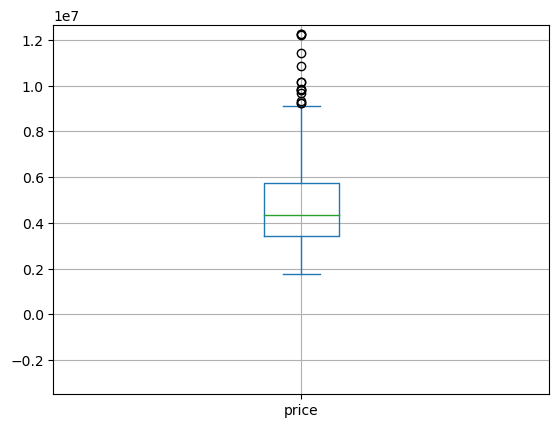

In [11]:
Q1 = df['price'].describe()['25%']
Q3 = df['price'].describe()['75%']
q1 = Q1 - 3 * (Q3 - Q1)
q3 = Q3 + 3 * (Q3 - Q1)

print(df['price'].describe())
boxplot = df['price'].plot.box(grid = True)
plt.ylim(q1, q3)
plt.show()

In [12]:
# Явное извлечение данных диаграммы
box_data = [item.get_ydata() for item in boxplot.findobj(plt.Line2D) if len(item.get_ydata()) == 2]

# Извлечение границ коробки и усов
box_upper_boundary = box_data[1][0]
whiskers_data = box_data[2:4]  # Corresponding to the upper whisker

# Извлечение информации о верхнем усе
upper_whisker = whiskers_data[1][1]

upper_whisker

9100000

In [13]:
df = df[df['price'] <= 9100000]
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 15 to 544
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                530 non-null    int64  
 1   area                 530 non-null    int64  
 2   bedrooms             530 non-null    int64  
 3   bathrooms            530 non-null    int64  
 4   stories              530 non-null    int64  
 5   parking              530 non-null    float64
 6   furnishingstatus     530 non-null    float64
 7   mainroad_yes         530 non-null    uint8  
 8   guestroom_yes        530 non-null    uint8  
 9   basement_yes         530 non-null    uint8  
 10  hotwaterheating_yes  530 non-null    uint8  
 11  airconditioning_yes  530 non-null    uint8  
 12  prefarea_yes         530 non-null    uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 36.2 KB


,price,area,bedrooms,bathrooms,stories,parking,furnishingstatus,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes
15,9100000,6000,4,1,2,2.000,0.500,1,0,1,0,0,0
16,9100000,6600,4,2,2,1.000,0.000,1,1,1,0,1,1
17,8960000,8500,3,2,4,2.000,0.500,1,0,0,0,1,0
18,8890000,4600,3,2,2,2.000,1.000,1,1,0,0,1,0
19,8855000,6420,3,2,2,1.000,0.500,1,0,0,0,1,1
20,8750000,4320,3,1,2,2.000,0.500,1,0,1,1,0,0
21,8680000,7155,3,2,1,2.000,0.000,1,0,1,0,1,0
22,8645000,8050,3,1,1,1.000,1.000,1,1,1,0,1,0
23,8645000,4560,3,2,2,1.000,1.000,1,1,1,0,1,0
24,8575000,8800,3,2,2,1.000,1.000,1,0,0,0,1,0


In [14]:
df['price'].describe()

count       530.000
mean    4600663.094
std     1596119.213
min     1750000.000
25%     3430000.000
50%     4270000.000
75%     5600000.000
max     9100000.000
Name: price, dtype: float64

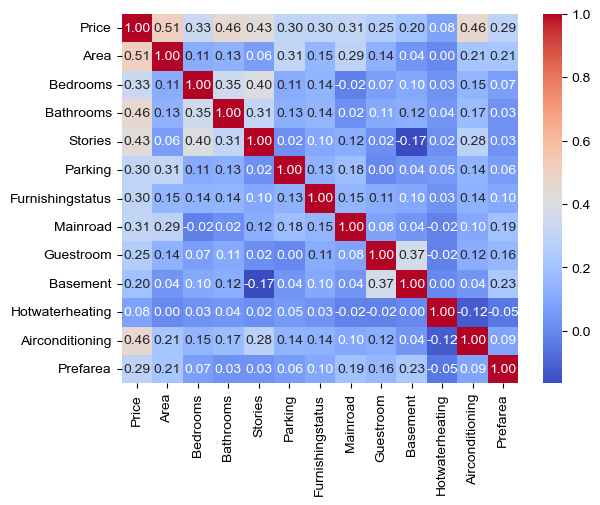

In [15]:
df_corr = pd.DataFrame({'Price': df['price'],
'Area': df['area'], 'Bedrooms':
df['bedrooms'], 'Bathrooms':
df['bathrooms'], 'Stories': df['stories'],
'Parking': df['parking'], 'Furnishingstatus':
df['furnishingstatus'], 'Mainroad': df['mainroad_yes'],
'Guestroom': df['guestroom_yes'], 'Basement': df['basement_yes'],
'Hotwaterheating': df['hotwaterheating_yes'], 'Airconditioning': df['airconditioning_yes'], 'Prefarea': df['prefarea_yes'], })

sns.heatmap(df_corr.corr(),cmap='coolwarm',annot=True, fmt = '.2f',)

sns.set(rc={'figure.figsize': (15, 17)})
plt.show()


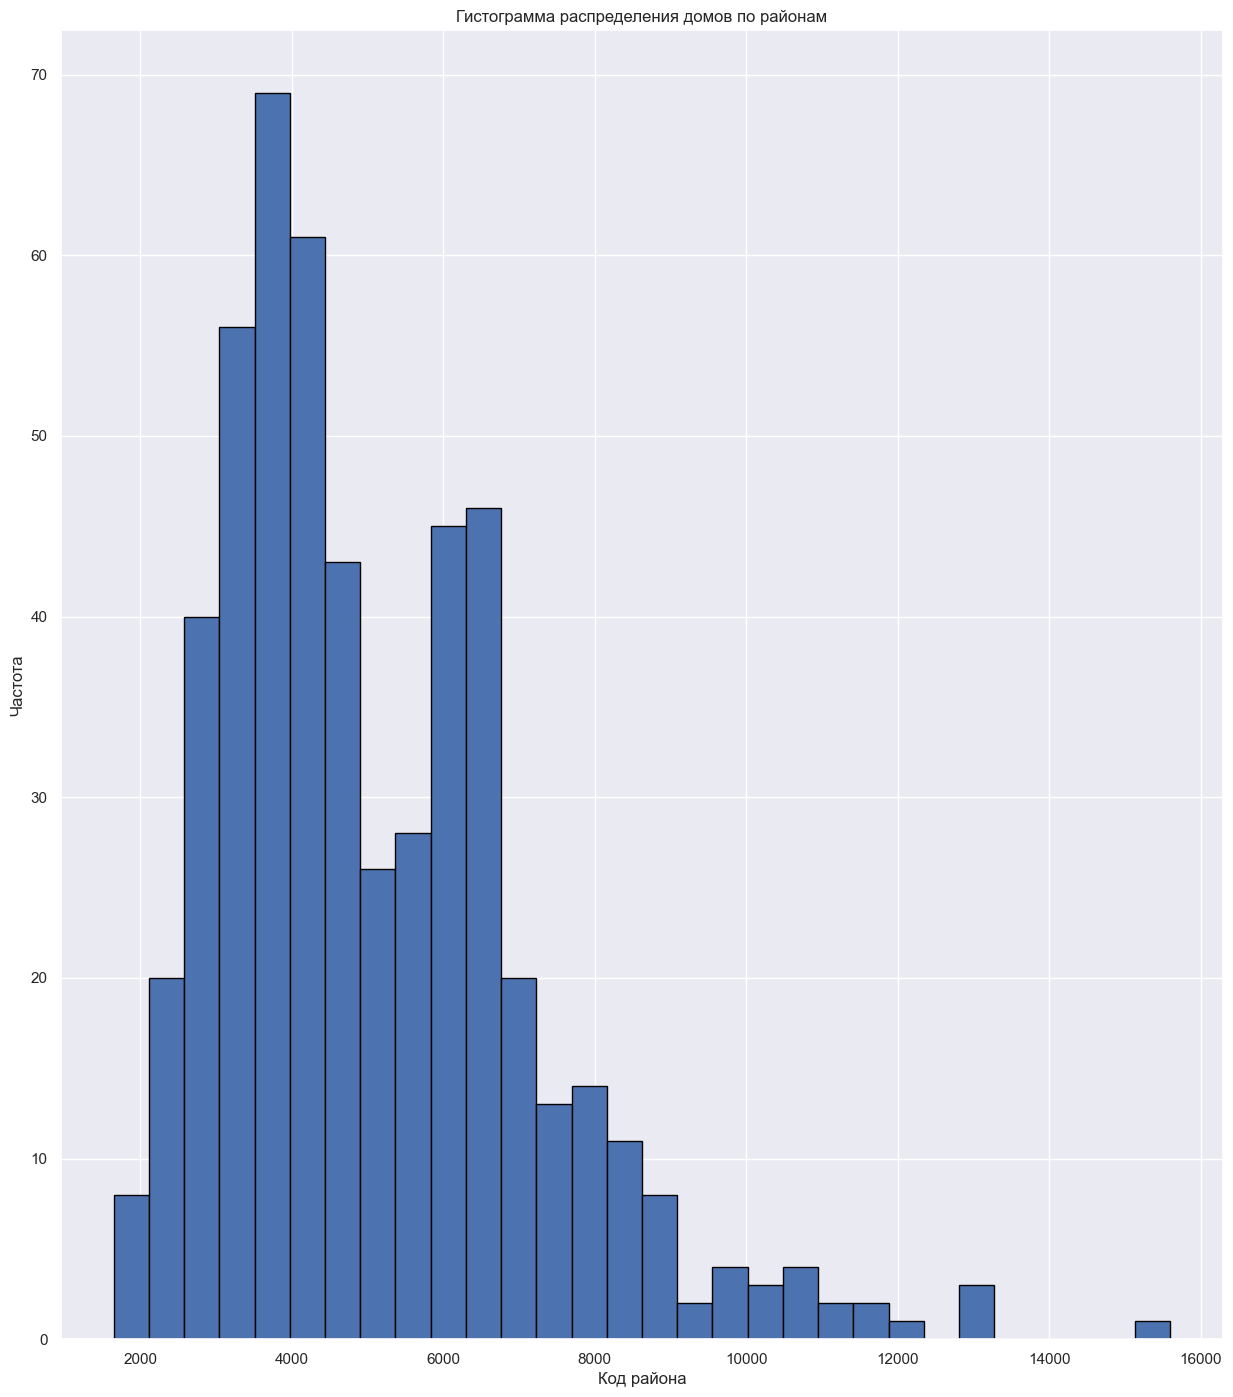

<Figure size 1500x1700 with 0 Axes>

In [16]:
data = df['area']

plt.hist(data, bins = 30, edgecolor = 'black')

plt.title('Гистограмма распределения домов по районам')
plt.xlabel('Код района')
plt.ylabel('Частота')
plt.figure(figsize=(15, 17))

plt.show()

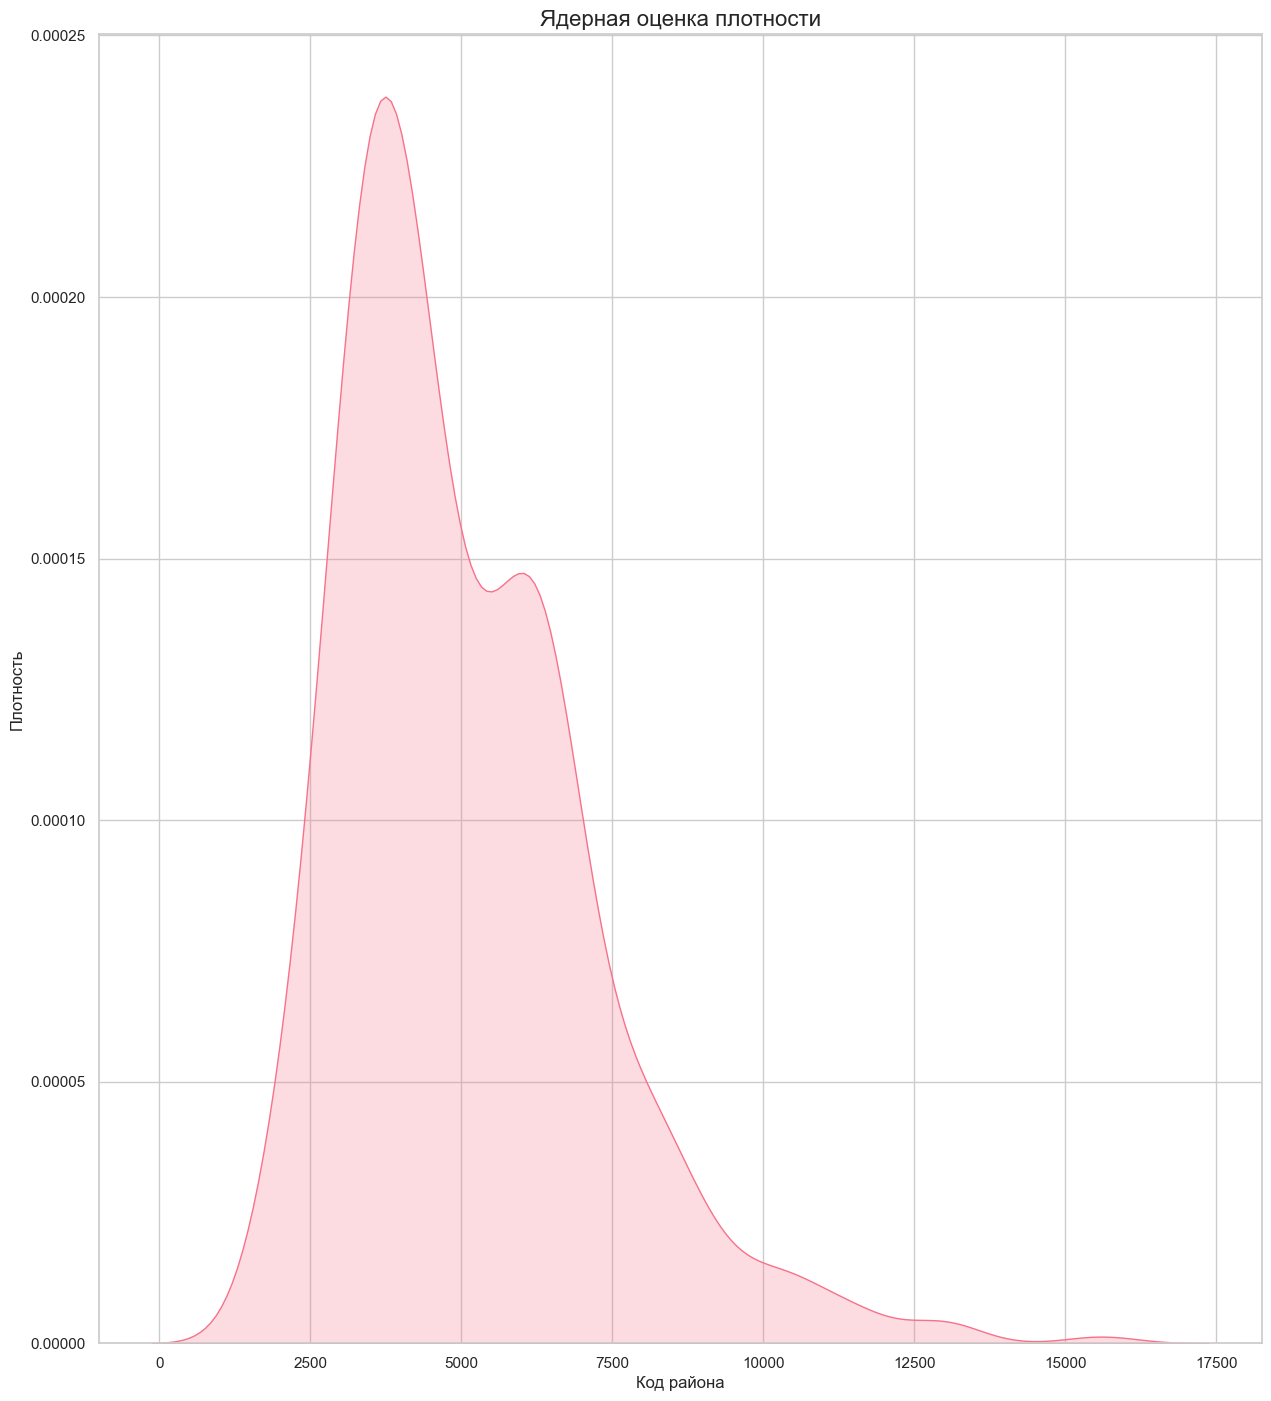

<Figure size 1500x1700 with 0 Axes>

In [17]:
sns.set(style = 'whitegrid')
sns.set_palette('husl')

sns.kdeplot(data, shade = 'True')

plt.title('Ядерная оценка плотности', fontsize=16)
plt.xlabel('Код района', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.figure(figsize=(15, 17))

plt.show()

In [18]:
#ЗАДАНИЕ 2

In [19]:
def assign_class(price):
    if price < 4270000:
        return 0
    else:
        return 1
    
df['class'] = df['price'].apply(assign_class)
print(df['price'], df['class'])

15     9100000
16     9100000
17     8960000
18     8890000
19     8855000
        ...   
540    1820000
541    1767150
542    1750000
543    1750000
544    1750000
Name: price, Length: 530, dtype: int64 15     1
16     1
17     1
18     1
19     1
      ..
540    0
541    0
542    0
543    0
544    0
Name: class, Length: 530, dtype: int64


In [20]:
features = df.drop(['class'], axis = 1)
target = df['class']

In [21]:
features_all, features_test, target_all, target_test = train_test_split(features, target, test_size = 0.2, random_state = 1, shuffle = True)
features_train, features_valid, target_train, target_valid = train_test_split(features_all, target_all, test_size = 0.25, random_state = 1, shuffle = True)

In [22]:
print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.6
--> валидация 0.2
--> тест 0.2


In [23]:
start_time = time.time_ns()
logistic = LogisticRegression()
logistic.fit(features_train, target_train)
logistic_predict = logistic.predict(features_valid)
print("{:.2f}".format(time.time_ns() - start_time), "nanoseconds")

accuracy = logistic.score(features_valid, target_valid)
print(f'Accuracy of logistic regression classifier on test set:  = {accuracy}')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(target_valid, logistic_predict)
class_report = classification_report(target_valid, logistic_predict, zero_division='warn')

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

11968000.00 nanoseconds
Accuracy of logistic regression classifier on test set:  = 0.6037735849056604
Confusion Matrix:
[[ 4 39]
 [ 3 60]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.09      0.16        43
           1       0.61      0.95      0.74        63

    accuracy                           0.60       106
   macro avg       0.59      0.52      0.45       106
weighted avg       0.59      0.60      0.51       106



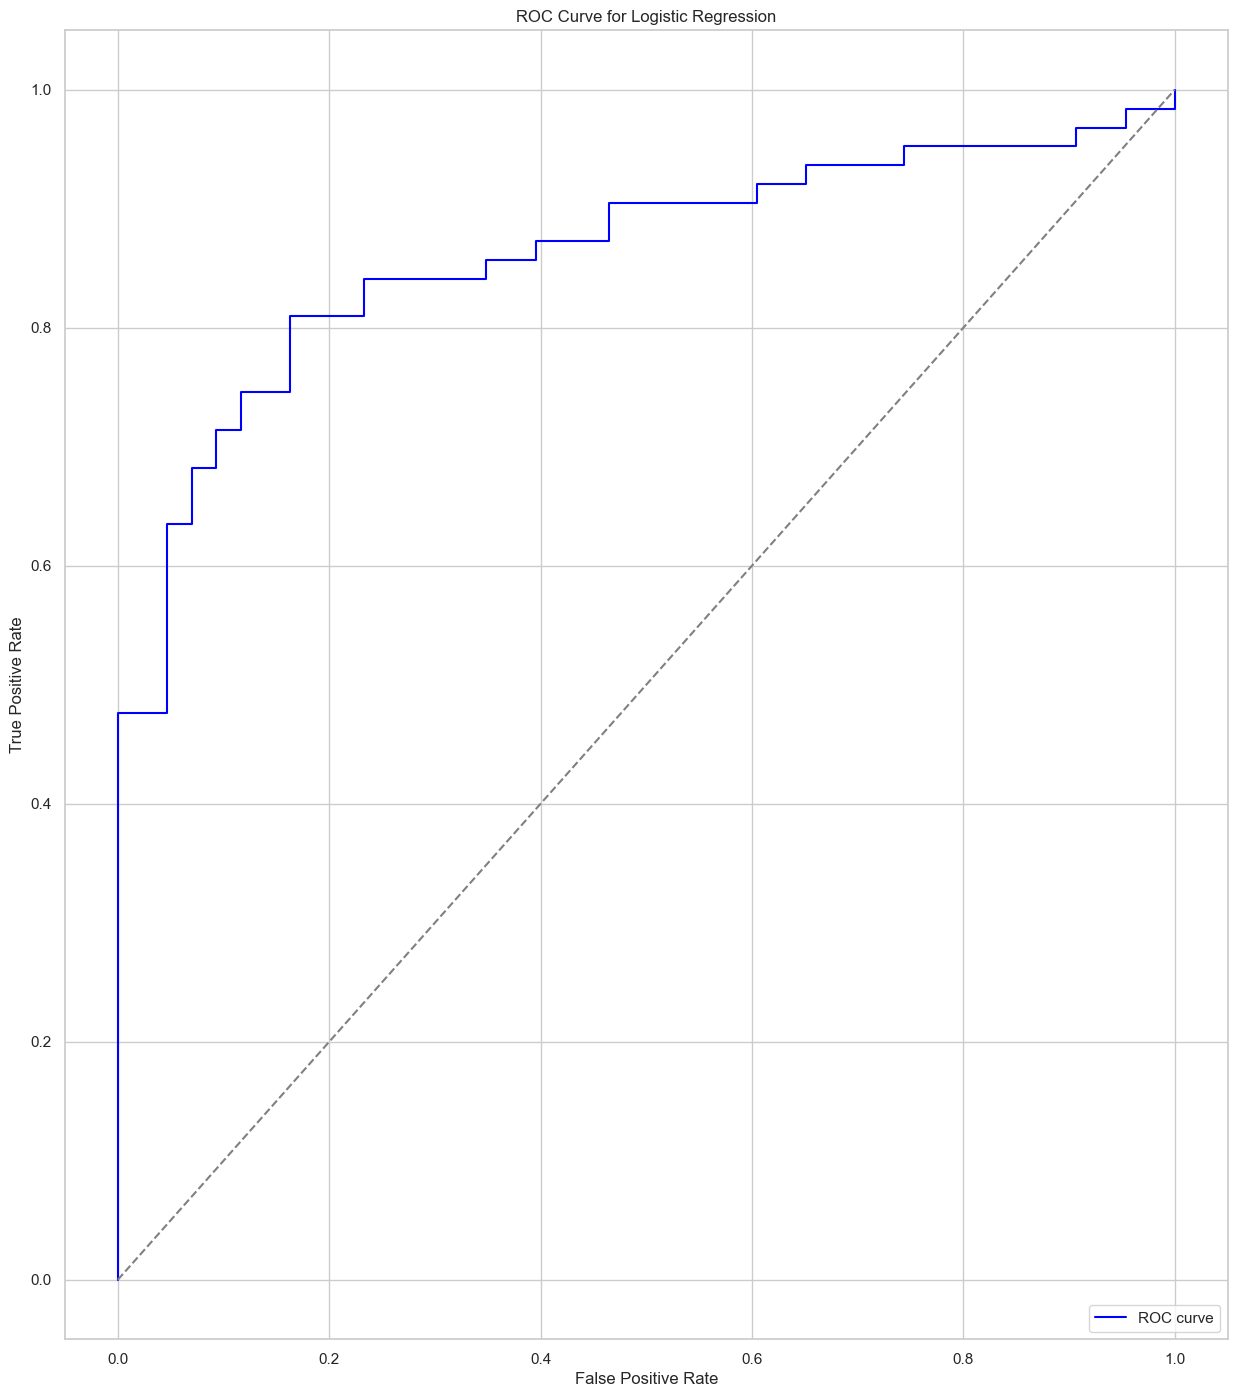

<Figure size 1500x1700 with 0 Axes>

In [24]:
from sklearn.metrics import roc_curve

# Получение вероятности принадлежности объектов к классу 1
probs = logistic.predict_proba(features_valid)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(target_valid, probs)

# Построение ROC-кривой
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.figure(figsize=(15, 17))

plt.show()

Accuracy for DummyClassifier: 0.4056603773584906
Confusion Matrix for DummyClassifier:
[[43  0]
 [63  0]]
Classification Report for DummyClassifier:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        43
           1       0.00      0.00      0.00        63

    accuracy                           0.41       106
   macro avg       0.20      0.50      0.29       106
weighted avg       0.16      0.41      0.23       106



C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


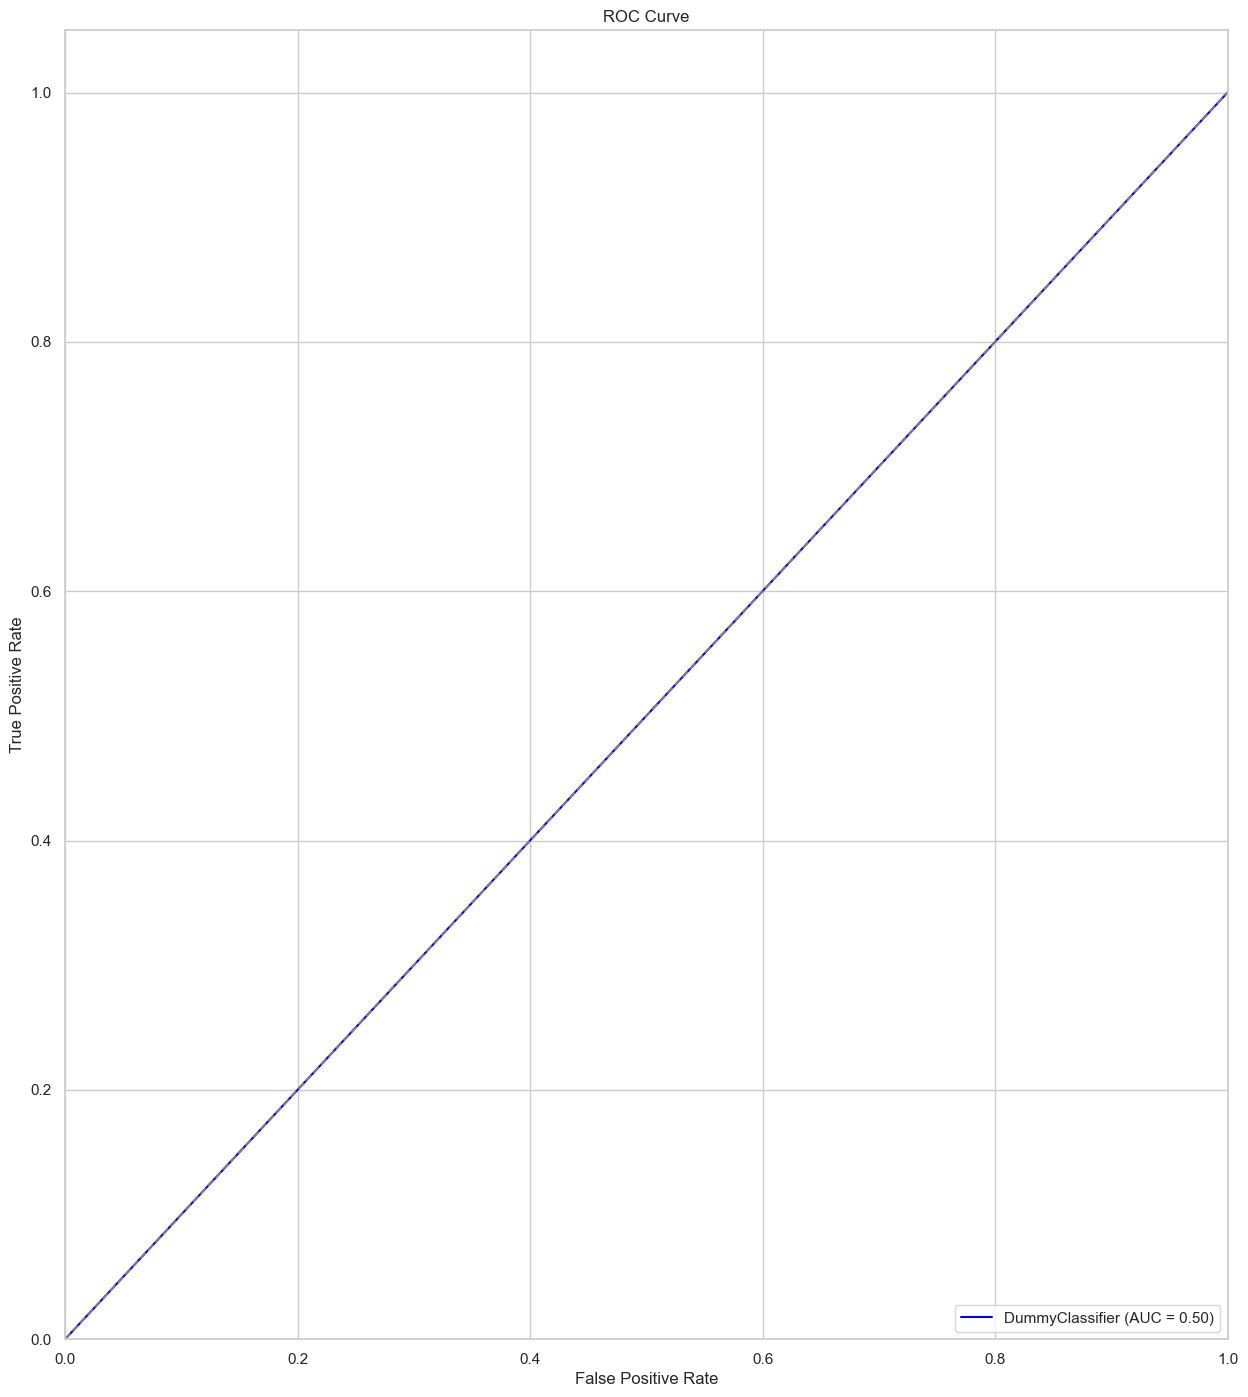

<Figure size 1500x1700 with 0 Axes>

Accuracy for DecisionTreeClassifier: 1.0
Confusion Matrix for DecisionTreeClassifier:
[[43  0]
 [ 0 63]]
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        63

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



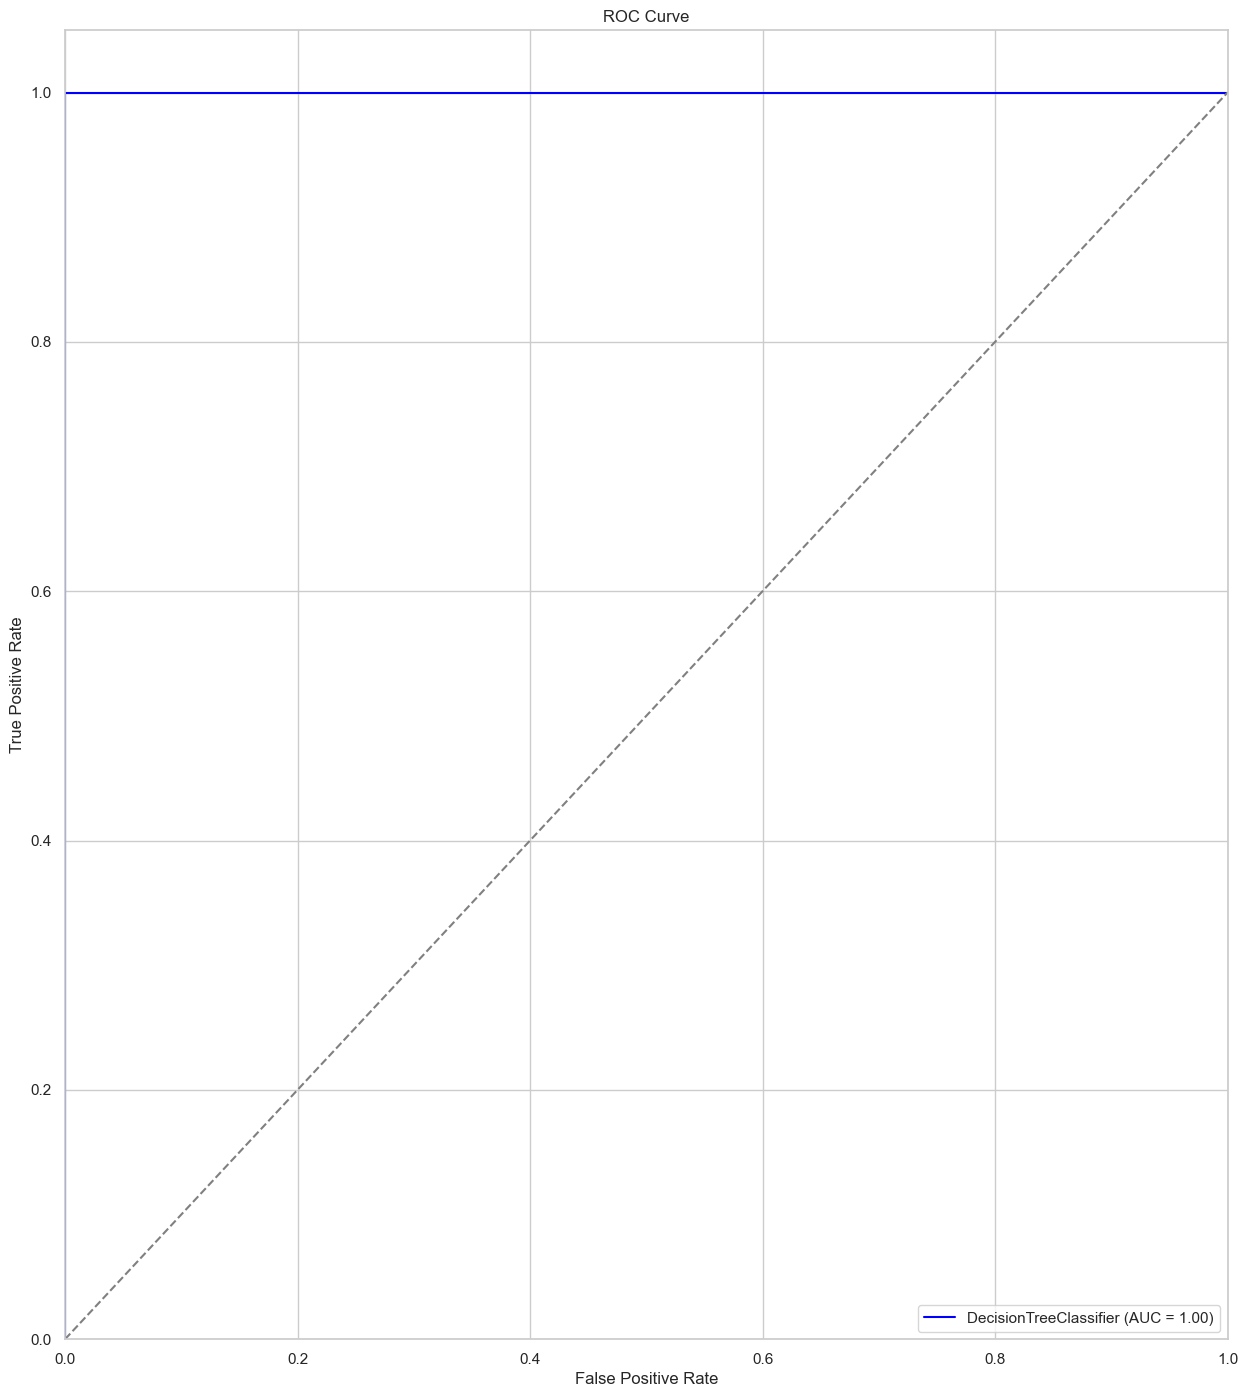

<Figure size 1500x1700 with 0 Axes>

Accuracy for RandomForestClassifier: 1.0
Confusion Matrix for RandomForestClassifier:
[[43  0]
 [ 0 63]]
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        63

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



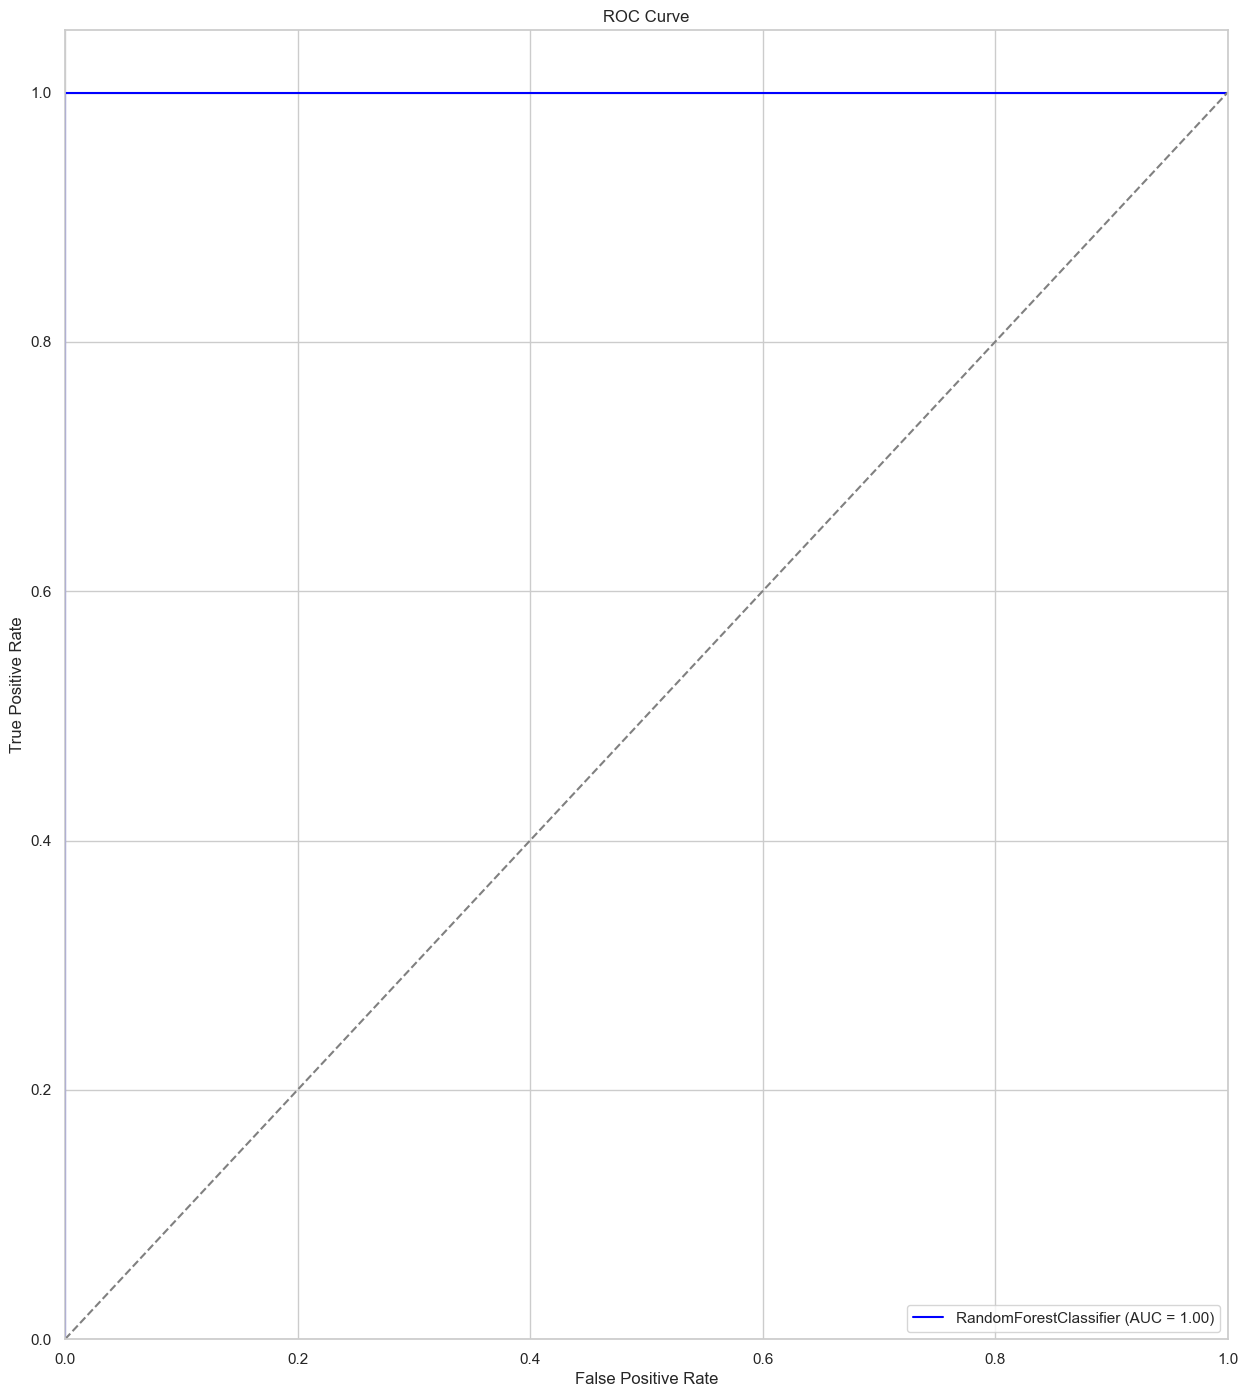

<Figure size 1500x1700 with 0 Axes>

Accuracy for GradientBoostingClassifier: 1.0
Confusion Matrix for GradientBoostingClassifier:
[[43  0]
 [ 0 63]]
Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        63

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



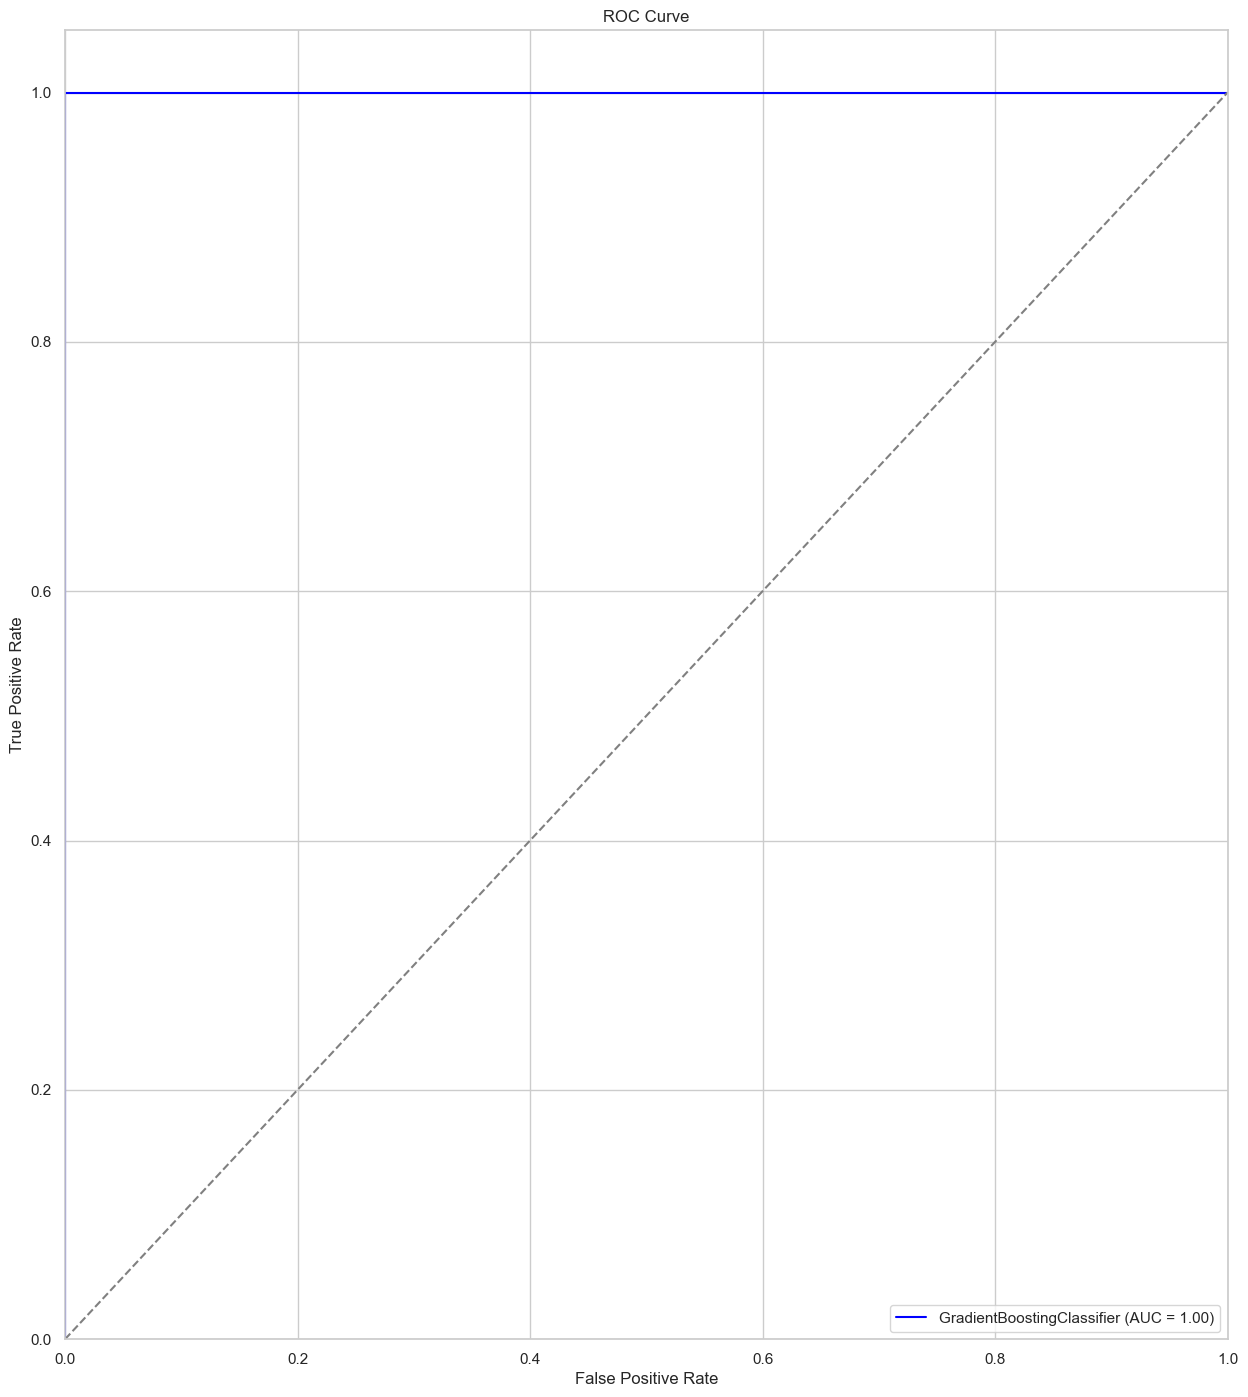

<Figure size 1500x1700 with 0 Axes>

Accuracy for SGDClassifier: 0.5943396226415094
Confusion Matrix for SGDClassifier:
[[ 0 43]
 [ 0 63]]
Classification Report for SGDClassifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.59      1.00      0.75        63

    accuracy                           0.59       106
   macro avg       0.30      0.50      0.37       106
weighted avg       0.35      0.59      0.44       106

No such attribute


C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score

classifiers = [DummyClassifier(strategy="most_frequent"),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier(),
               SGDClassifier()]

for clf in classifiers:
    clf.fit(features_train, target_train)
    predictions = clf.predict(features_valid)
    
    accuracy = accuracy_score(target_valid, predictions)
    print(f"Accuracy for {clf.__class__.__name__}: {accuracy}")
    
    conf_matrix = confusion_matrix(target_valid, predictions)
    print(f"Confusion Matrix for {clf.__class__.__name__}:\n{conf_matrix}")
    
    class_report = classification_report(target_valid, predictions)
    print(f"Classification Report for {clf.__class__.__name__}:\n{class_report}")
    
    if hasattr(clf, "predict_proba"):
        probabilities = clf.predict_proba(features_valid)[:, 1]
        fpr, tpr, _ = roc_curve(target_valid, probabilities)
        roc_auc = roc_auc_score(target_valid, probabilities)
        
        plt.plot(fpr, tpr, color='blue', label=f"{clf.__class__.__name__} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.figure(figsize=(15, 17))

        plt.show()
        
    else:
        print('No such attribute')

In [28]:
#min     1750000.000
#25%     3430000.000
#50%     4270000.000
#75%     5600000.000
#max     9100000.000

def change_class(price):
    if price <= 3430000:
        return 0
    elif price <= 4270000:
        return 1
    elif price <= 5600000:
        return 2
    else:
        return 3
    
df['class'] = df['price'].apply(change_class)
features = df.drop(['class'], axis = 1)
target = df['class']
print(df['price'], df['class'])

15     9100000
16     9100000
17     8960000
18     8890000
19     8855000
        ...   
540    1820000
541    1767150
542    1750000
543    1750000
544    1750000
Name: price, Length: 530, dtype: int64 15     3
16     3
17     3
18     3
19     3
      ..
540    0
541    0
542    0
543    0
544    0
Name: class, Length: 530, dtype: int64


C:\Games\anacondajup\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


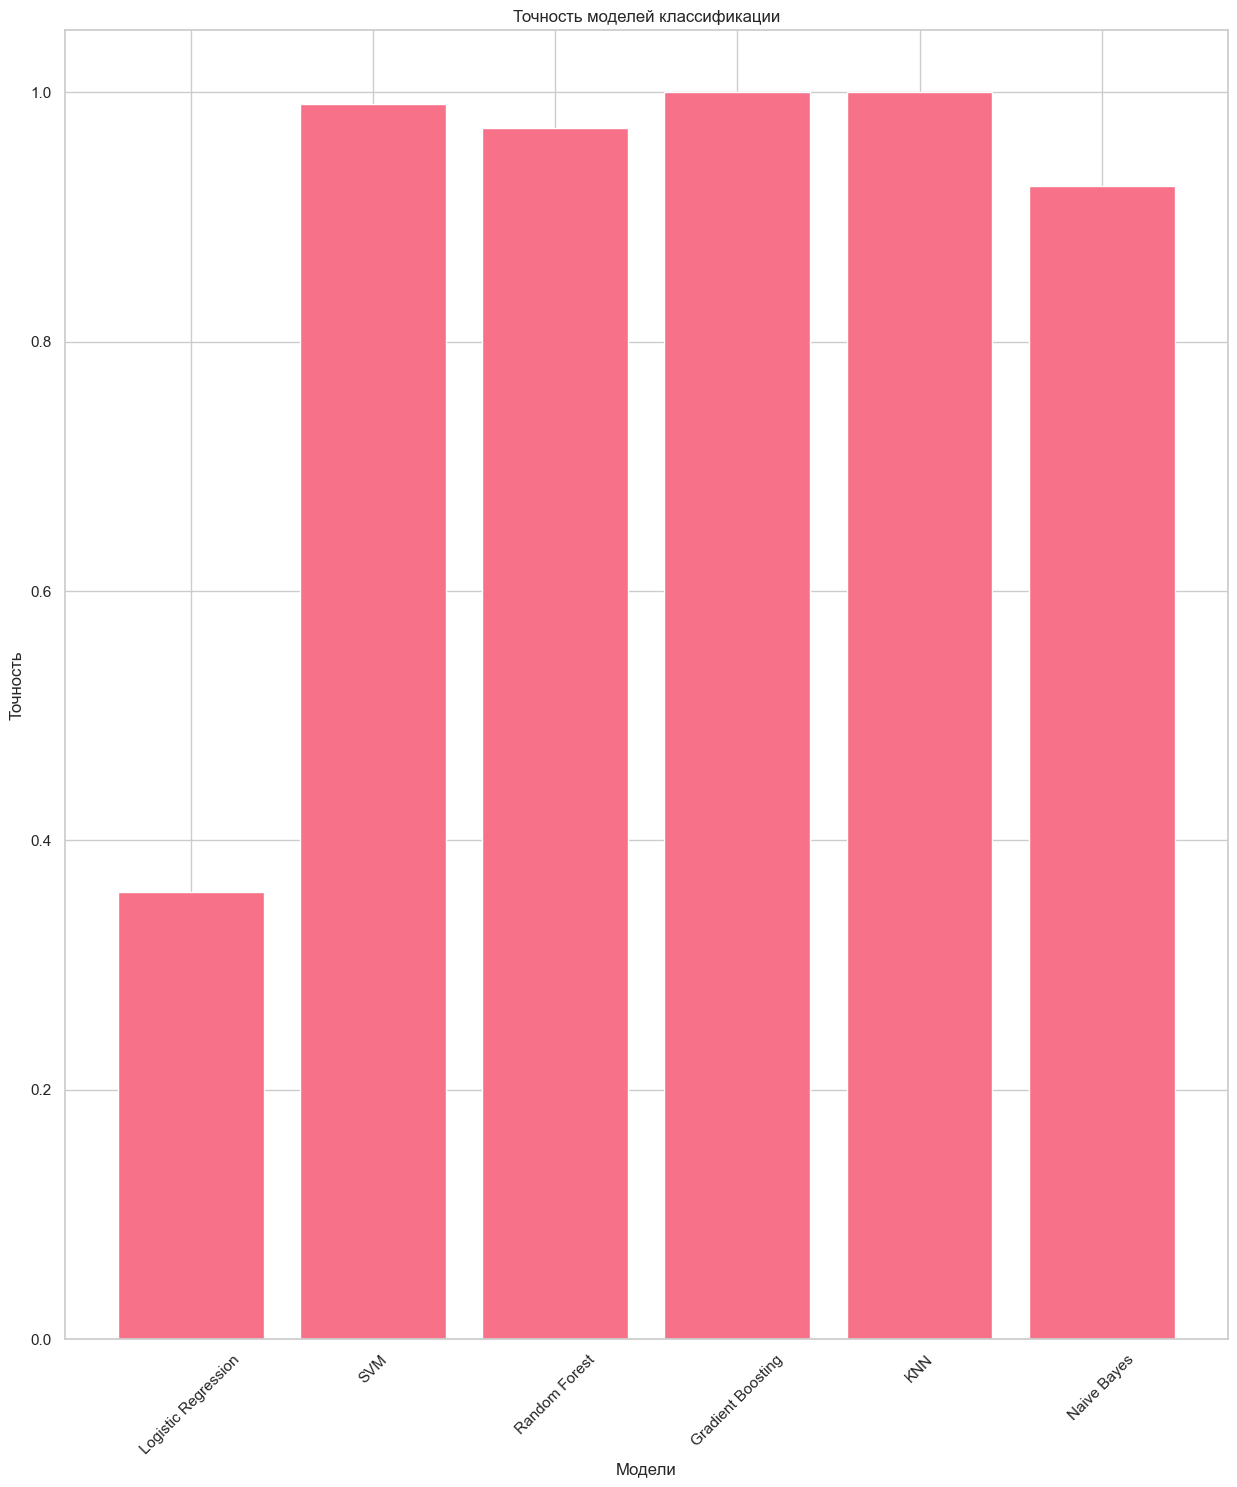

<Figure size 500x700 with 0 Axes>

Точность на тестовом наборе для Logistic Regression: 0.24528301886792453
Confusion Matrix for SGDClassifier:
[[ 1  0  6 17]
 [ 0  0  6 14]
 [ 4  0  6 20]
 [ 3  0  8 21]]
Classification Report for SGDClassifier:
              precision    recall  f1-score   support

           0       0.12      0.04      0.06        24
           1       0.00      0.00      0.00        20
           2       0.23      0.20      0.21        30
           3       0.29      0.66      0.40        32

    accuracy                           0.26       106
   macro avg       0.16      0.22      0.17       106
weighted avg       0.18      0.26      0.20       106

Точность на тестовом наборе для SVM: 0.9528301886792453
Confusion Matrix for SGDClassifier:
[[ 4  9  8  3]
 [ 7  5  3  5]
 [11  7  8  4]
 [ 7 10  7  8]]
Classification Report for SGDClassifier:
              precision    recall  f1-score   support

           0       0.14      0.17      0.15        24
           1       0.16      0.25      0.20        

C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Games\anacondajup\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Точность на тестовом наборе для Gradient Boosting: 1.0
Confusion Matrix for SGDClassifier:
[[ 4  8  9  3]
 [ 7  4  4  5]
 [12  6  8  4]
 [ 8  8  8  8]]
Classification Report for SGDClassifier:
              precision    recall  f1-score   support

           0       0.13      0.17      0.15        24
           1       0.15      0.20      0.17        20
           2       0.28      0.27      0.27        30
           3       0.40      0.25      0.31        32

    accuracy                           0.23       106
   macro avg       0.24      0.22      0.22       106
weighted avg       0.26      0.23      0.24       106

Точность на тестовом наборе для KNN: 1.0
Confusion Matrix for SGDClassifier:
[[ 4  8  9  3]
 [ 7  4  4  5]
 [12  6  8  4]
 [ 8  8  8  8]]
Classification Report for SGDClassifier:
              precision    recall  f1-score   support

           0       0.13      0.17      0.15        24
           1       0.15      0.20      0.17        20
           2       0.28      0

C:\Games\anacondajup\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


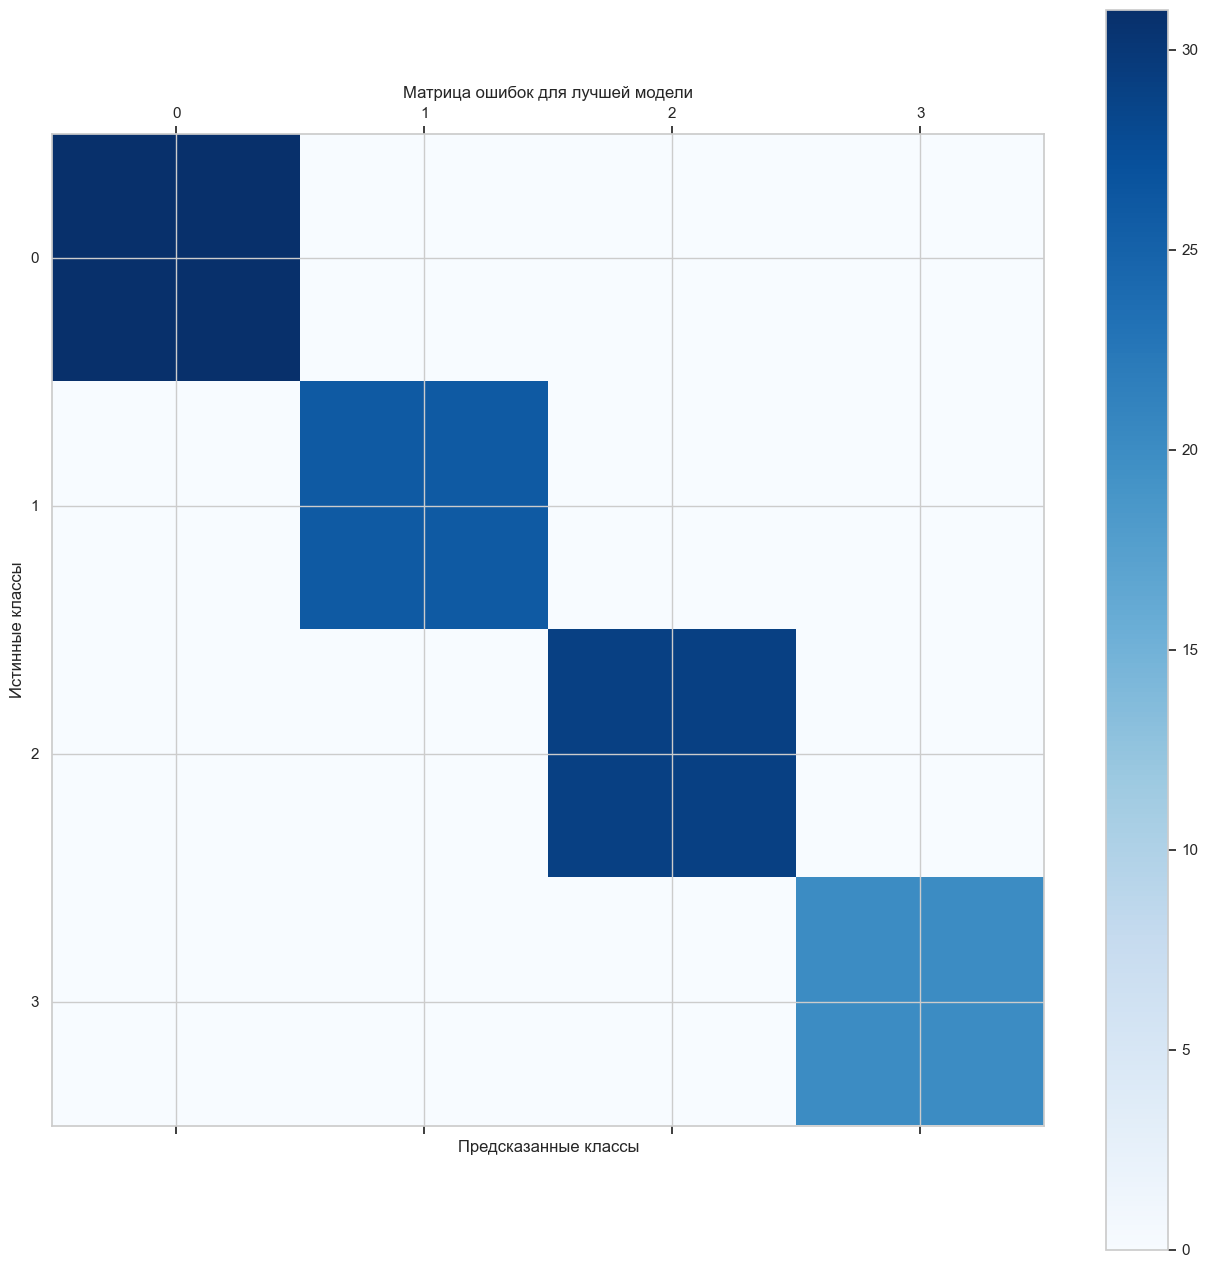

In [27]:
# Импорт необходимых библиотек
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Разделение данных на обучающий, валидационный и тестовый наборы
features_all, features_test, target_all, target_test = train_test_split(features, target, test_size=0.2, random_state=1, shuffle=True)
features_train, features_valid, target_train, target_valid = train_test_split(features_all, target_all, test_size=0.25, random_state=1, shuffle=True)

# Инициализация моделей
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Обучение моделей и оценка точности
accuracies = {}
for name, model in models.items():
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    accuracies[name] = accuracy

# Построение графика точности каждой модели
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.title('Точность моделей классификации')
plt.xticks(rotation=45)
plt.figure(figsize=(5, 7))

plt.show()

# Оценка на тестовом наборе
for name, model in models.items():
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    accuracy_test = accuracy_score(target_test, predictions)
    print(f"Точность на тестовом наборе для {name}: {accuracy_test}")
    
    conf_matrix = confusion_matrix(target_valid, predictions)
    print(f"Confusion Matrix for {clf.__class__.__name__}:\n{conf_matrix}")
    
    class_report = classification_report(target_valid, predictions)
    print(f"Classification Report for {clf.__class__.__name__}:\n{class_report}")

# График матрицы ошибок для лучшей модели
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
conf_matrix = confusion_matrix(target_test, predictions)

plt.matshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок для лучшей модели')
plt.show()

In [4]:
a = [1, 2, 3, 4, 5]
b = [2, 3, 4, 5, 6]

res = list(map(lambda x, y: x * y, a, b))

In [5]:
res

[2, 6, 12, 20, 30]